In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
file = 'global_data_4_0.5'
time_bins = np.arange(0,24,float(file.split('_')[-1]))
H_bins = np.arange(90,130,float(file.split('_')[-2]))

shape = len(time_bins) * len(H_bins)

file_path = f'../../Output/{file}.csv'

In [9]:
data_df = pd.read_csv(file_path,low_memory=False)
Ne_EXP = np.array(data_df['EXP Density']).reshape(-1,shape)
dNe_EXP =  np.array(data_df['EXP Density Error']).reshape(-1,shape)
Ne_WACCM = np.array(data_df['WACCM Density']).reshape(-1,shape)
mag_EXP = np.array(data_df['EXP Magnitude']).reshape(-1,shape)
mag_WACCM = np.array(data_df['WACCM Magnitude']).reshape(-1,shape)
height = np.array(data_df['Height']).reshape(-1,shape)
time = np.array(data_df['Hours']).reshape(-1,shape)
Date = np.array(data_df['Date']).reshape(-1,shape)[:,0]
Svalbard = np.array(data_df ['Svalbard']).reshape(-1,shape)[:,0] == 1
Tromso = np.array(data_df['Tromso']).reshape(-1,shape)[:,0] == 1
Geomagnetic_Event = np.array(data_df['Geomagnetic Event']).reshape(-1,shape)[:,0] == 1
Solar_Proton_Event = np.array(data_df['Solar Proton Event']).reshape(-1,shape)[:,0] == 1
dst_index = np.array(data_df['DST Index']).reshape(-1,shape)
ddst_index = np.array(data_df['DST Index Gradient']).reshape(-1,shape)
hp30_index = np.array(data_df['Hp30 Index']).reshape(-1,shape)
dhp30_index = np.array(data_df['Hp30 Index Gradient']).reshape(-1,shape)
IMF_index = np.array(data_df['IMF']).reshape(-1,shape)
dIMF_index = np.array(data_df['IMF Gradient']).reshape(-1,shape)
SML_index = np.array(data_df['SML']).reshape(-1,shape)
dSML_index = np.array(data_df['SML Gradient']).reshape(-1,shape)
SMU_index = np.array(data_df['SMU']).reshape(-1,shape)
dSMU_index = np.array(data_df['SMU Gradient']).reshape(-1,shape)
SME_index = np.array(data_df['SME']).reshape(-1,shape)
dSME_index = np.array(data_df['SME Gradient']).reshape(-1,shape)
speed_index = np.array(data_df['Speed 1 hour before']).reshape(-1,shape)
dspeed_index = np.array(data_df['Speed Gradient 1 hour before']).reshape(-1,shape)

Ne_EXP_gradient_height = mag_EXP.reshape(-1, len(H_bins), len(time_bins))
zero_gradient_mask = Ne_EXP_gradient_height == 0
Ne_EXP_gradient_height = (Ne_EXP_gradient_height[:,1:,:] - Ne_EXP_gradient_height[:,:-1,:])/(H_bins[1]-H_bins[0])
Ne_EXP_gradient_height = np.concatenate((Ne_EXP_gradient_height, Ne_EXP_gradient_height[:,-1:,:]), axis=1)
Ne_EXP_gradient_height[np.roll(zero_gradient_mask,1,axis=1)] = Ne_EXP_gradient_height[np.roll(zero_gradient_mask,2,axis=1)]
Ne_EXP_gradient_height[np.roll(zero_gradient_mask,-1,axis=1)] = Ne_EXP_gradient_height[np.roll(zero_gradient_mask,-2,axis=1)]
Ne_EXP_gradient_height = Ne_EXP_gradient_height.reshape(-1,shape)

Ne_EXP_gradient_time = mag_EXP.reshape(-1, len(H_bins), len(time_bins))
zero_gradient_mask = Ne_EXP_gradient_time == 0
Ne_EXP_gradient_time = (Ne_EXP_gradient_time[:,:,1:] -  Ne_EXP_gradient_time[:,:,:-1])/time_bins[1]
Ne_EXP_gradient_time = np.concatenate((Ne_EXP_gradient_time, Ne_EXP_gradient_time[:,:,-1:]), axis=2)
Ne_EXP_gradient_time[np.roll(zero_gradient_mask,1,axis=1)] = Ne_EXP_gradient_time[np.roll(zero_gradient_mask,2,axis=1)]
Ne_EXP_gradient_time[np.roll(zero_gradient_mask,-1,axis=1)] = Ne_EXP_gradient_time[np.roll(zero_gradient_mask,-2,axis=1)]
Ne_EXP_gradient_time = Ne_EXP_gradient_time.reshape(-1,shape)

masks = [Svalbard, Geomagnetic_Event, (~Geomagnetic_Event) * (~Solar_Proton_Event), Tromso, Solar_Proton_Event, (Geomagnetic_Event) + (Solar_Proton_Event)]
types = ['Svalbard', 'Geomagnetic Storms', 'Quiet', 'Tromso', 'Solar Proton', 'Active']

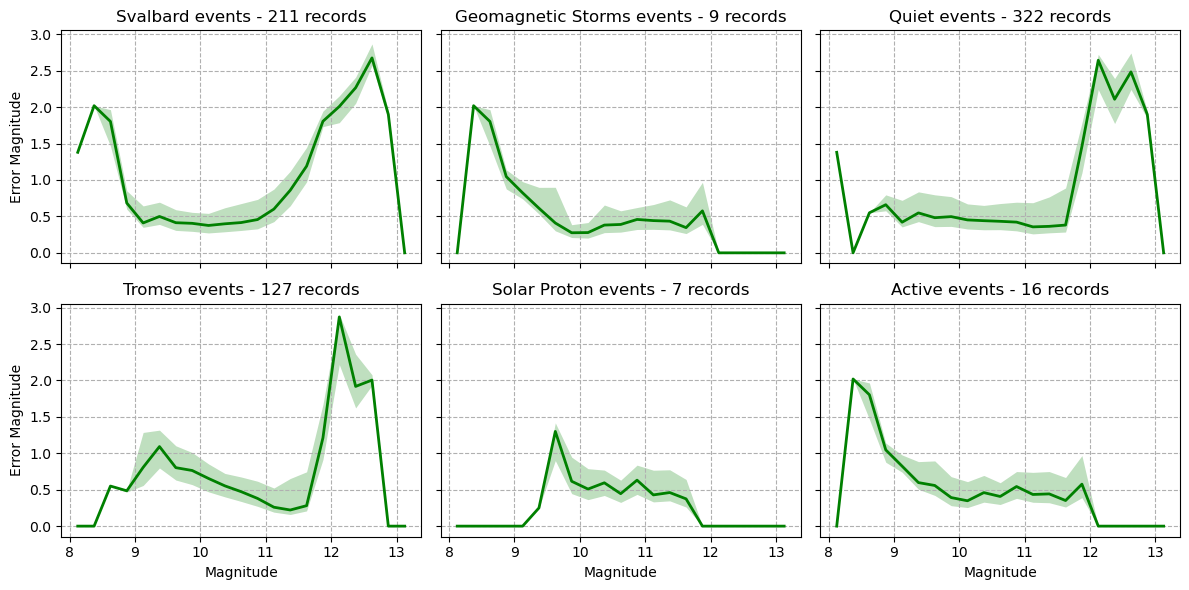

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

mag_bins = np.linspace(8,13,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_mag = mag_EXP[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    mag_flat = temp_mag[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []

    for mag_bin in mag_bins:
        mag_mask = np.abs(mag_flat - mag_bin) <= (mag_bins[1] - mag_bins[0])/2
        if len(Ne_diff_flat[mag_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[mag_mask])
            less_sigma_value = np.std(np.concatenate((Ne_diff_flat[mag_mask][Ne_diff_flat[mag_mask]<mean_value], [mean_value])))
            more_sigma_value = np.std(np.concatenate((Ne_diff_flat[mag_mask][Ne_diff_flat[mag_mask]>mean_value], [mean_value])))
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(mag_bins)

    axs[i // 3][i % 3].fill_between(x + (mag_bins[1] - mag_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (mag_bins[1] - mag_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'Magnitude')
axs[1][1].set_xlabel(r'Magnitude')
axs[1][2].set_xlabel(r'Magnitude')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/density.png')
plt.show()

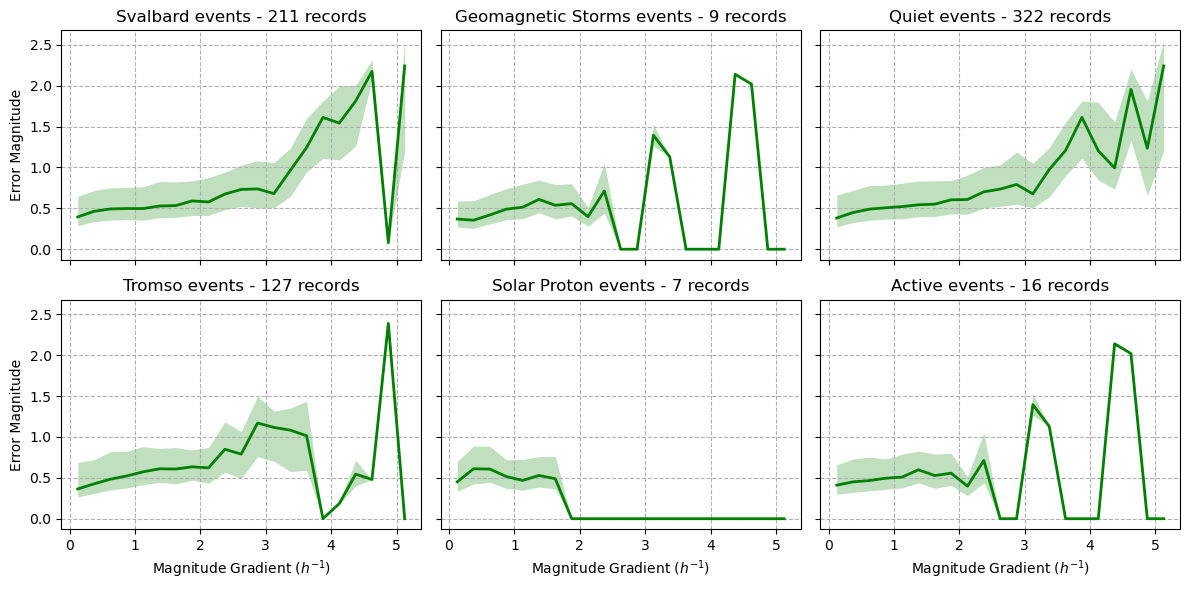

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

gradient_bins = np.linspace(0,5,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_gradient = Ne_EXP_gradient_time[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    gradient_flat = np.abs(temp_gradient[value_mask])

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for gradient_bin in gradient_bins:
        gradient_mask = np.abs(gradient_flat - gradient_bin) <= (gradient_bins[1] - gradient_bins[0])/2
        if len(Ne_diff_flat[gradient_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[gradient_mask])
            less_sigma_value = np.std(np.concatenate((Ne_diff_flat[gradient_mask][Ne_diff_flat[gradient_mask]<mean_value], [mean_value])))
            more_sigma_value = np.std(np.concatenate((Ne_diff_flat[gradient_mask][Ne_diff_flat[gradient_mask]>mean_value], [mean_value])))
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(gradient_bins)

    axs[i // 3][i % 3].fill_between(x + (gradient_bins[1] - gradient_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (gradient_bins[1] - gradient_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'Magnitude Gradient ($h^{-1})$')
axs[1][1].set_xlabel(r'Magnitude Gradient ($h^{-1})$')
axs[1][2].set_xlabel(r'Magnitude Gradient ($h^{-1})$')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/density-gradient.png')
plt.show()

Mean magnitude error: 0.44 - Sigmas:0.12 and 0.24
Mean magnitude error: 0.4 - Sigmas:0.1 and 0.25
Mean magnitude error: 0.43 - Sigmas:0.11 and 0.26
Mean magnitude error: 0.41 - Sigmas:0.11 and 0.29
Mean magnitude error: 0.5 - Sigmas:0.12 and 0.25
Mean magnitude error: 0.44 - Sigmas:0.11 and 0.26


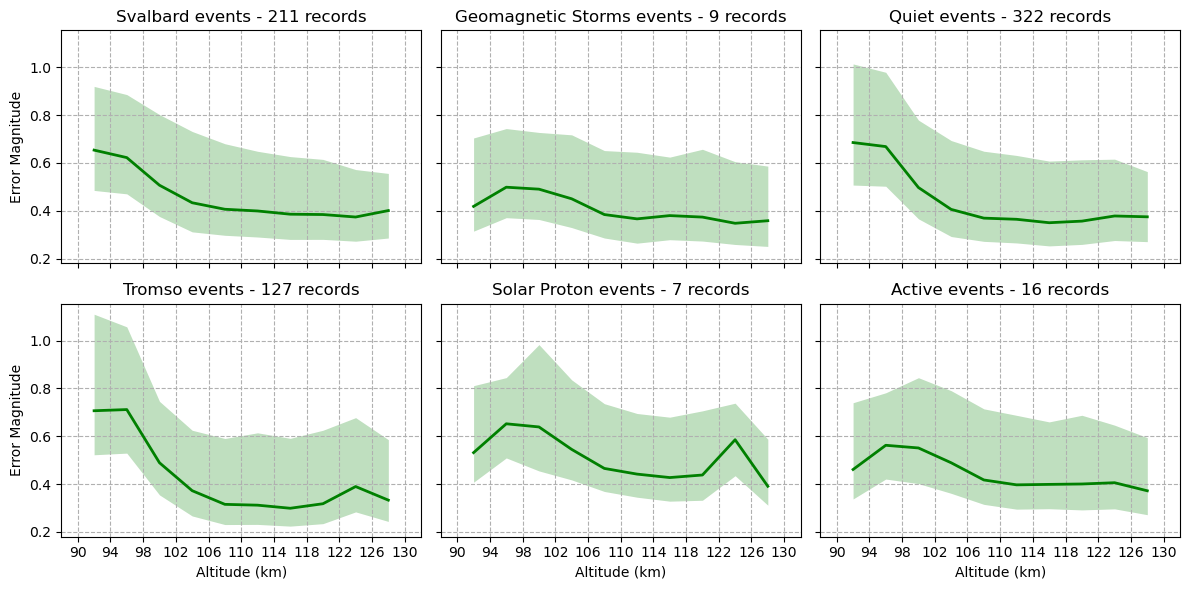

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)


for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_height = height[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    height_flat = temp_height[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for H_bin in H_bins:
        h_mask = height_flat == H_bin
        mean_value = np.mean(Ne_diff_flat[h_mask])
        mean_list.append(mean_value)
        less_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]<mean_value]))
        more_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]>mean_value]))

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(H_bins)

    axs[i // 3][i % 3].fill_between(x + (H_bins[1] - H_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (H_bins[1] - H_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')
    print(f'Mean magnitude error: {int(100*np.mean(Ne_diff_flat))/100} - Sigmas:{int(100*np.mean(less_sigma))/100} and {int(100*np.mean(more_sigma))/100}')

axs[1][0].set_xlabel('Altitude (km)')
axs[1][1].set_xlabel('Altitude (km)')
axs[1][2].set_xlabel('Altitude (km)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.xticks(np.concatenate((H_bins,[130])))
plt.xlim((88, 132))
plt.savefig(f'../../Output/Figures/error-events/height.png')
plt.show()

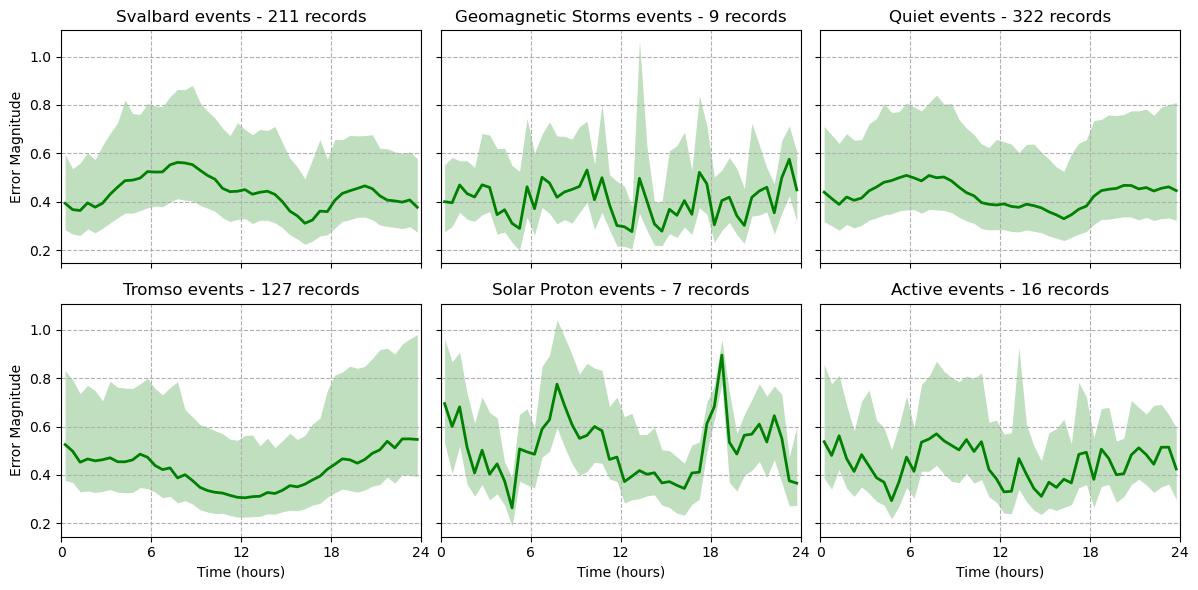

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)


for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_time = time[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    time_flat = temp_time[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for time_bin in time_bins:
        time_mask = time_flat == time_bin
        mean_value = np.mean(Ne_diff_flat[time_mask])
        mean_list.append(mean_value)
        less_sigma_list.append(np.std(Ne_diff_flat[time_mask][Ne_diff_flat[time_mask]<mean_value]))
        more_sigma_list.append(np.std(Ne_diff_flat[time_mask][Ne_diff_flat[time_mask]>mean_value]))

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(time_bins)

    axs[i // 3][i % 3].fill_between(x + time_bins[1]/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + time_bins[1]/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel('Time (hours)')
axs[1][1].set_xlabel('Time (hours)')
axs[1][2].set_xlabel('Time (hours)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.xticks(np.linspace(0,24,5).astype(int))
plt.xlim((0, 24))
plt.savefig(f'../../Output/Figures/error-events/time.png')
plt.show()

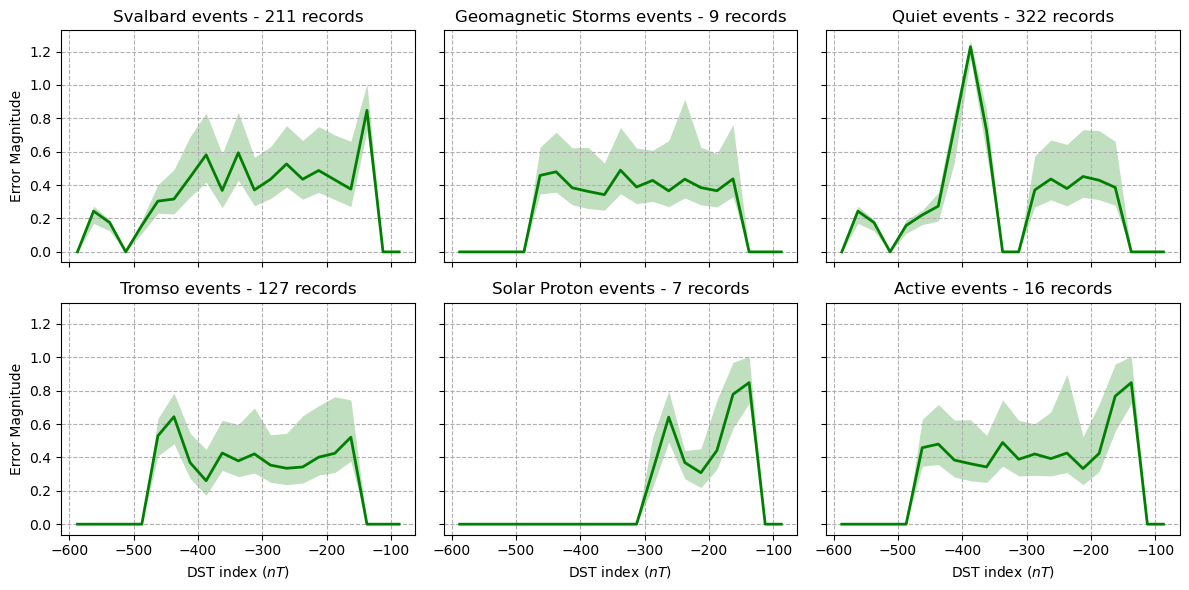

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-400,100,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dst_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + index_bins[1]/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + index_bins[1]/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'DST index ($nT$)')
axs[1][1].set_xlabel(r'DST index ($nT$)')
axs[1][2].set_xlabel(r'DST index ($nT$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/DST.png')
plt.show()

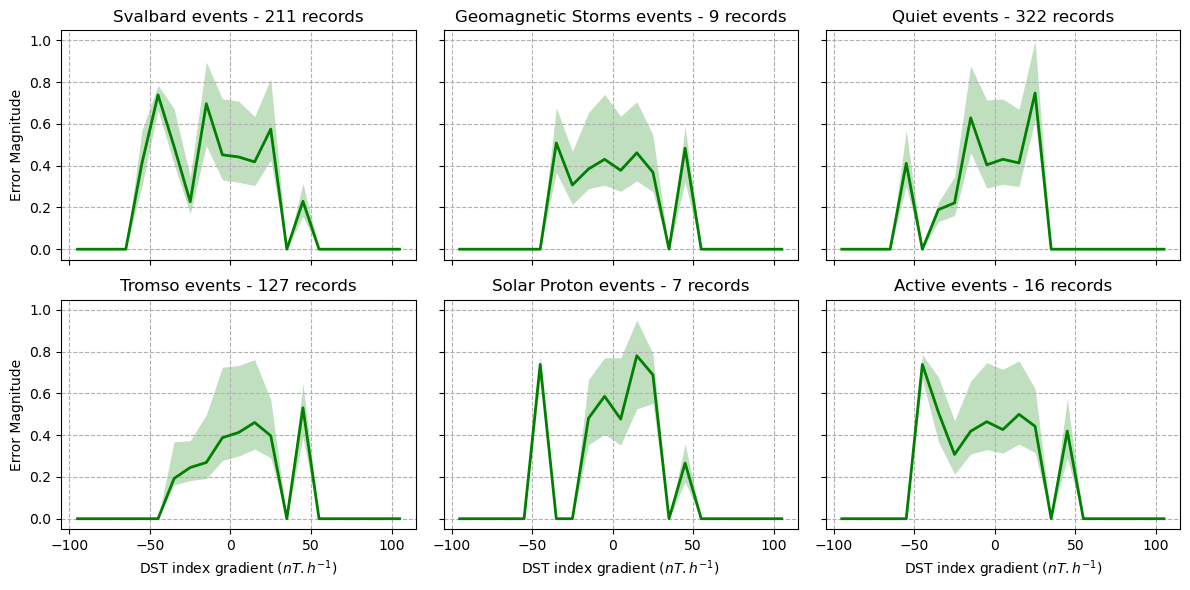

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-100,100,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = ddst_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'DST index gradient ($nT.h^{-1}$)')
axs[1][1].set_xlabel(r'DST index gradient ($nT.h^{-1}$)')
axs[1][2].set_xlabel(r'DST index gradient ($nT.h^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/DST-gradient.png')
plt.show()

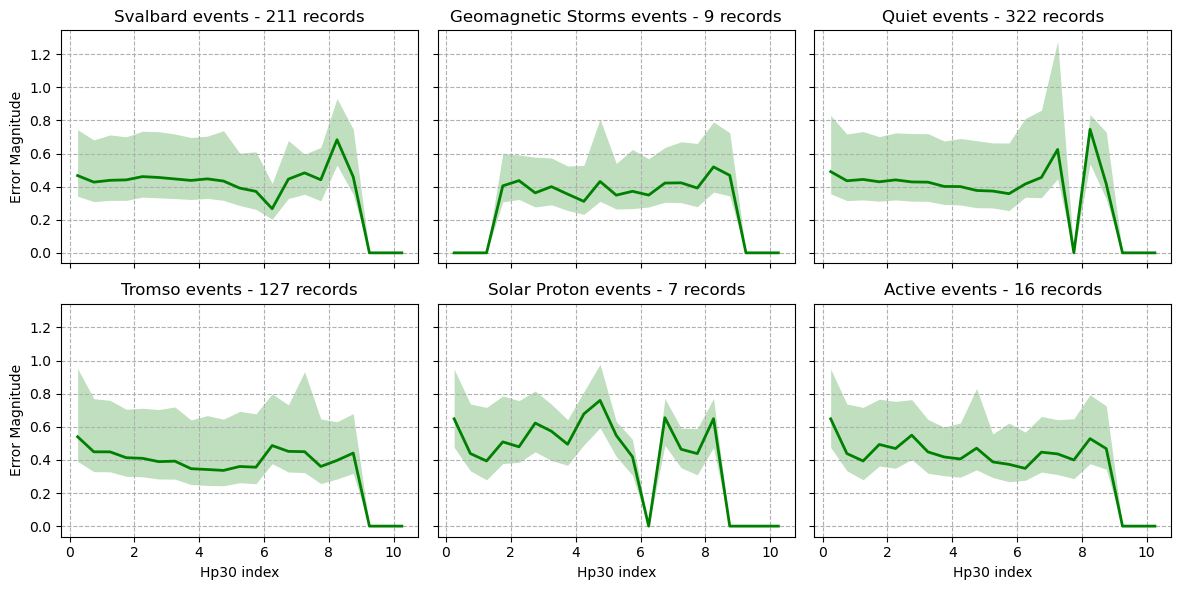

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(0,1000,21).astype(int)/100

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = hp30_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + index_bins[1]/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + index_bins[1]/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel('Hp30 index')
axs[1][1].set_xlabel('Hp30 index')
axs[1][2].set_xlabel('Hp30 index')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/HP30.png')
plt.show()

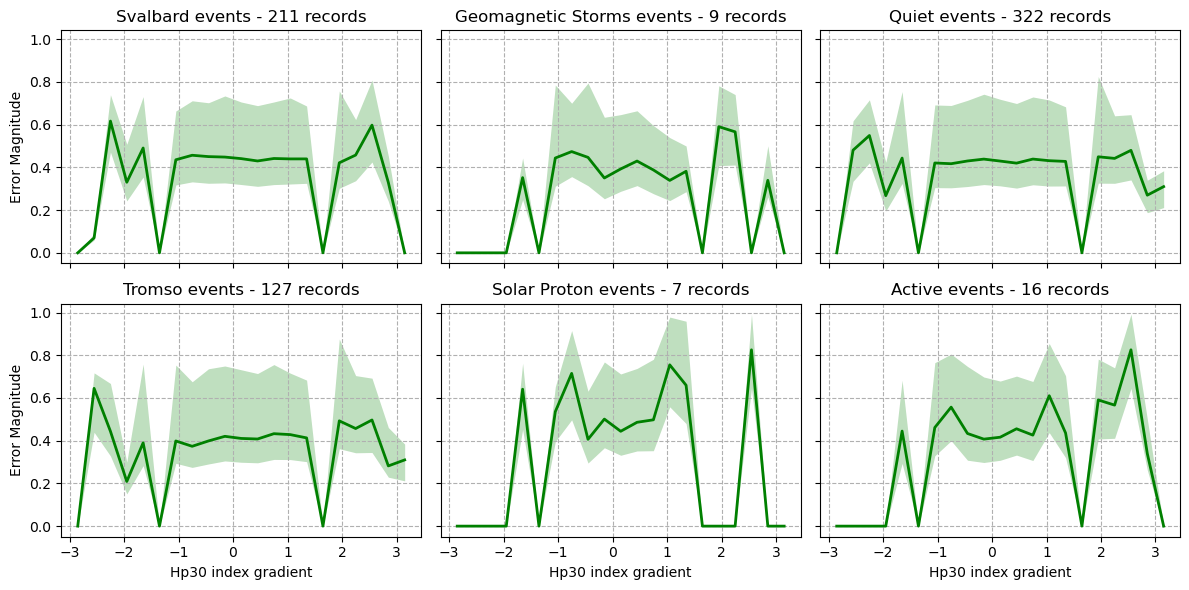

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-300,300,21).astype(int)/100

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dhp30_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel('Hp30 index gradient')
axs[1][1].set_xlabel('Hp30 index gradient')
axs[1][2].set_xlabel('Hp30 index gradient')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/HP30-gradient.png')
plt.show()

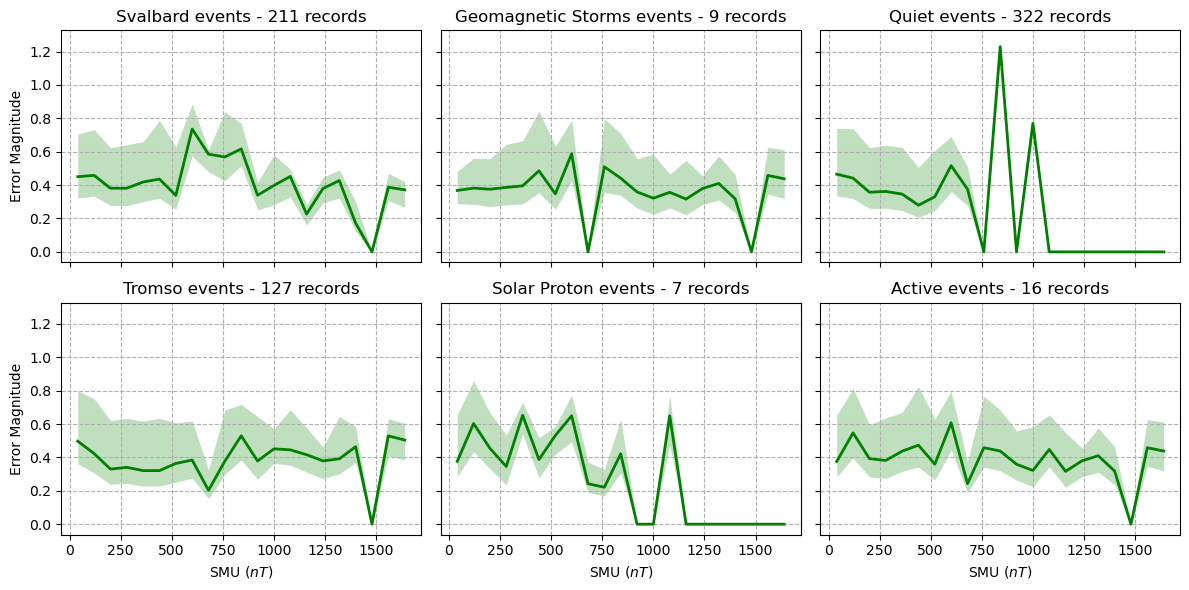

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(0,1600,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = SMU_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + index_bins[1]/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + index_bins[1]/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SMU ($nT$)')
axs[1][1].set_xlabel(r'SMU ($nT$)')
axs[1][2].set_xlabel(r'SMU ($nT$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SMU.png')
plt.show()

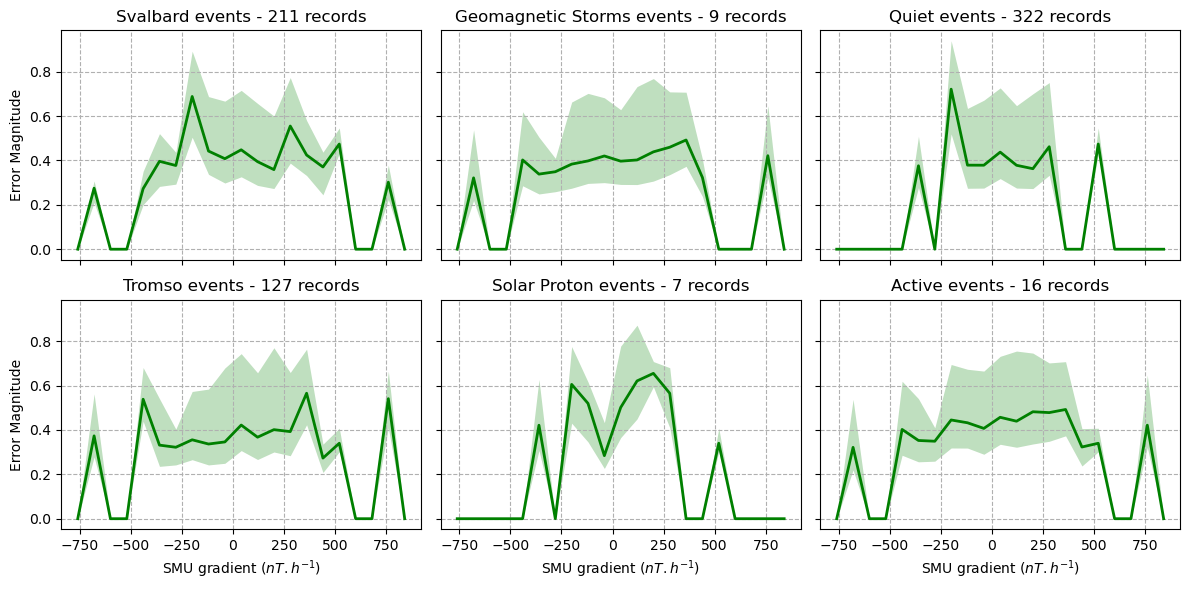

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-800,800,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dSMU_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SMU gradient ($nT.h^{-1}$)')
axs[1][1].set_xlabel(r'SMU gradient ($nT.h^{-1}$)')
axs[1][2].set_xlabel(r'SMU gradient ($nT.h^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SMU-gradient.png')
plt.show()

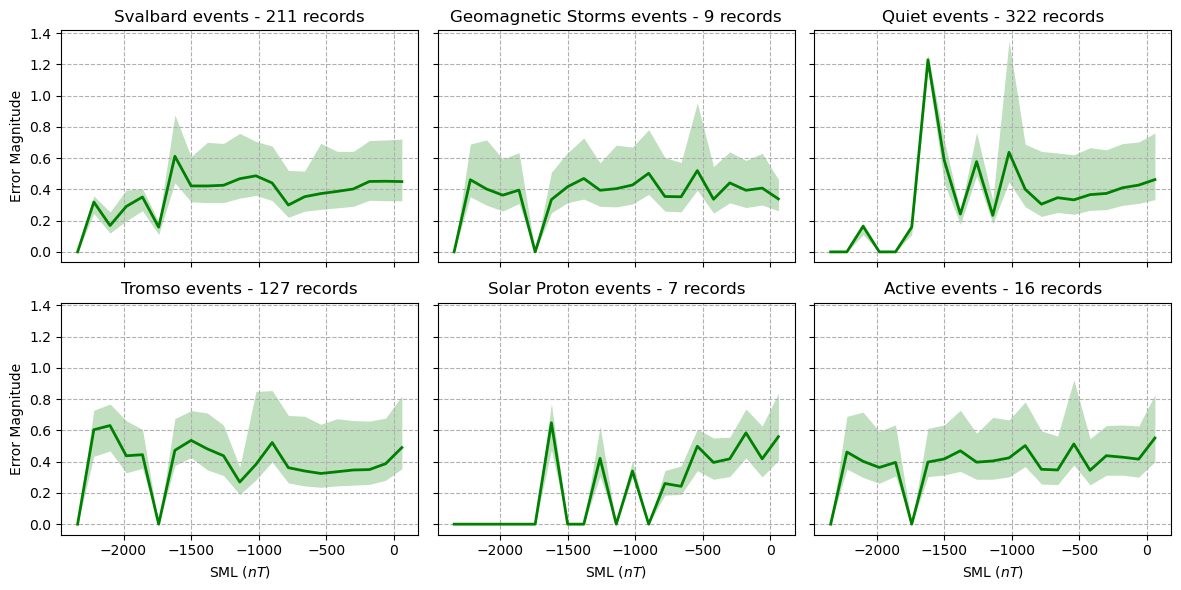

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-2400,0,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = SML_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SML ($nT$)')
axs[1][1].set_xlabel(r'SML ($nT$)')
axs[1][2].set_xlabel(r'SML ($nT$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SML.png')
plt.show()

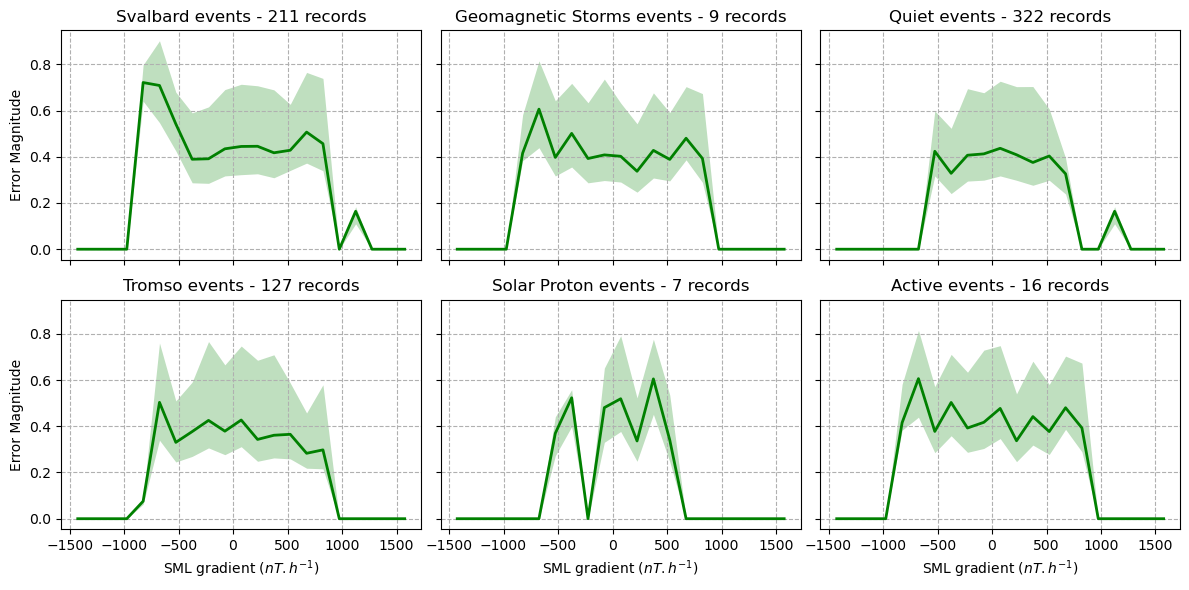

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-1500,1500,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dSML_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SML gradient ($nT.h^{-1}$)')
axs[1][1].set_xlabel(r'SML gradient ($nT.h^{-1}$)')
axs[1][2].set_xlabel(r'SML gradient ($nT.h^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SML-gradient.png')
plt.show()

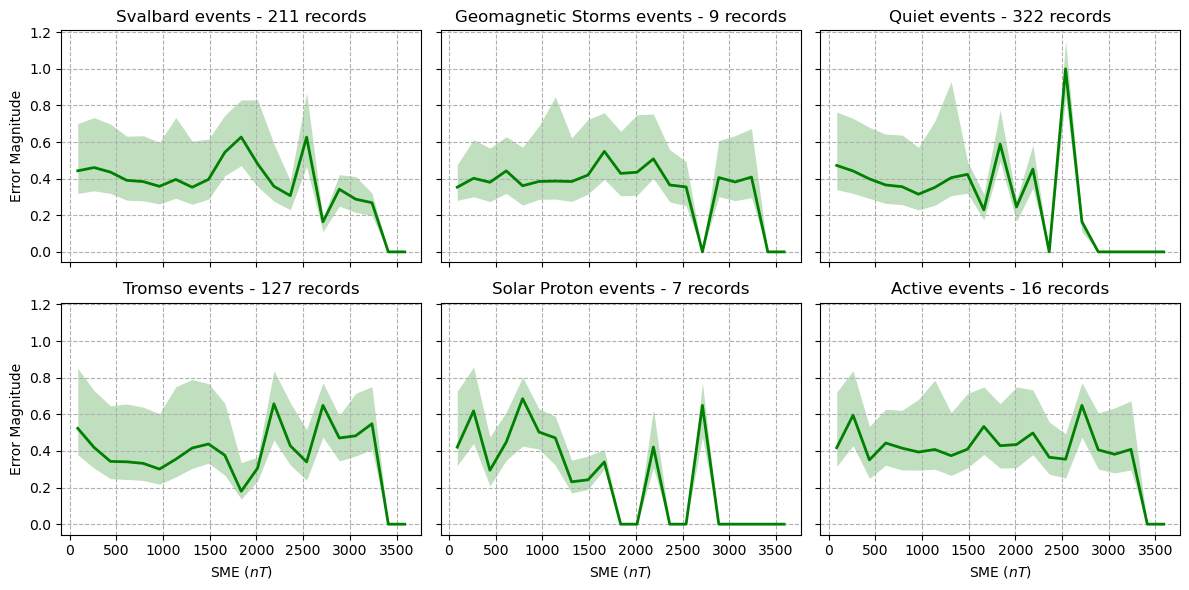

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(0,3500,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = SME_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SME ($nT$)')
axs[1][1].set_xlabel(r'SME ($nT$)')
axs[1][2].set_xlabel(r'SME ($nT$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SME.png')
plt.show()

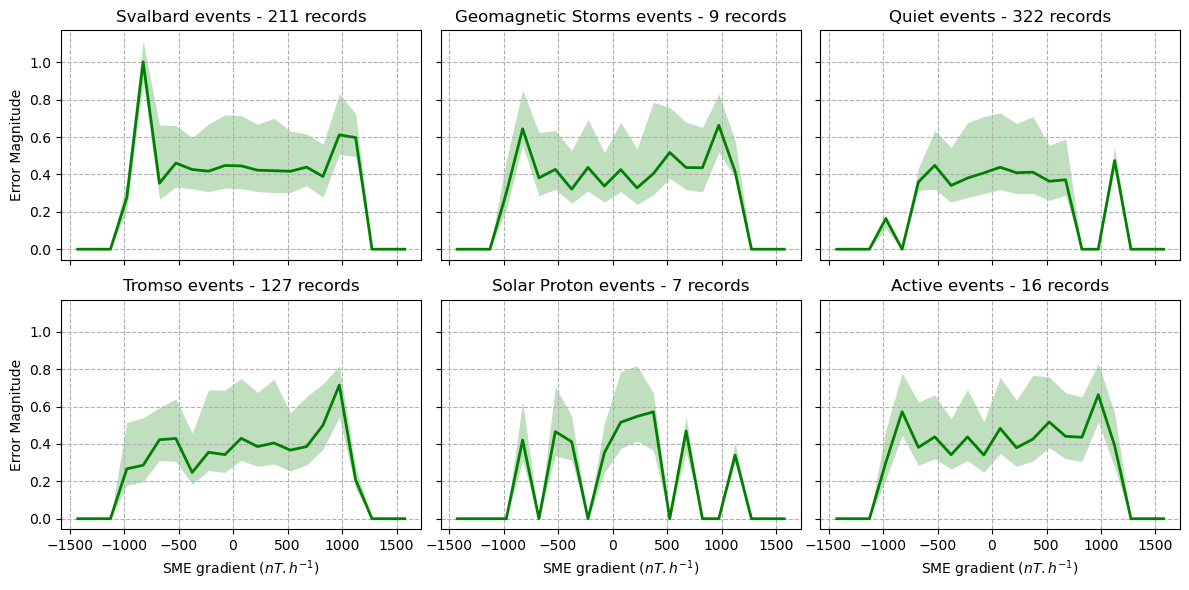

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-1500,1500,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dSME_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'SME gradient ($nT.h^{-1}$)')
axs[1][1].set_xlabel(r'SME gradient ($nT.h^{-1}$)')
axs[1][2].set_xlabel(r'SME gradient ($nT.h^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/SME-gradient.png')
plt.show()

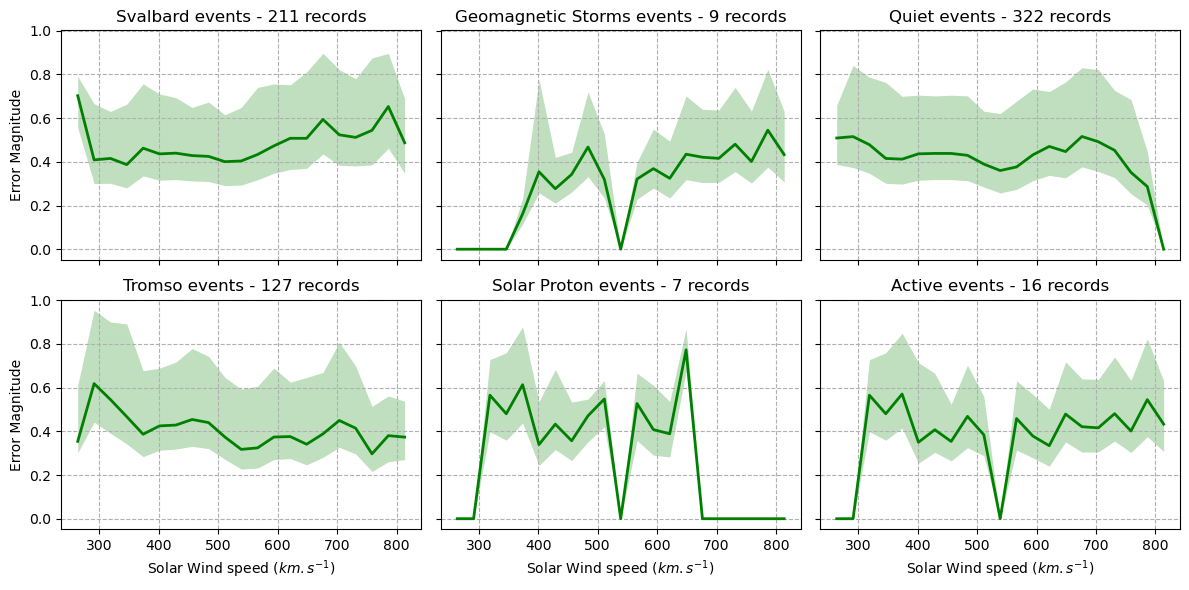

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(250,800,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = speed_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + (index_bins[1]-index_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + (index_bins[1]-index_bins[0])/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'Solar Wind speed ($km.s^{-1}$)')
axs[1][1].set_xlabel(r'Solar Wind speed ($km.s^{-1}$)')
axs[1][2].set_xlabel(r'Solar Wind speed ($km.s^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/speed.png')
plt.show()

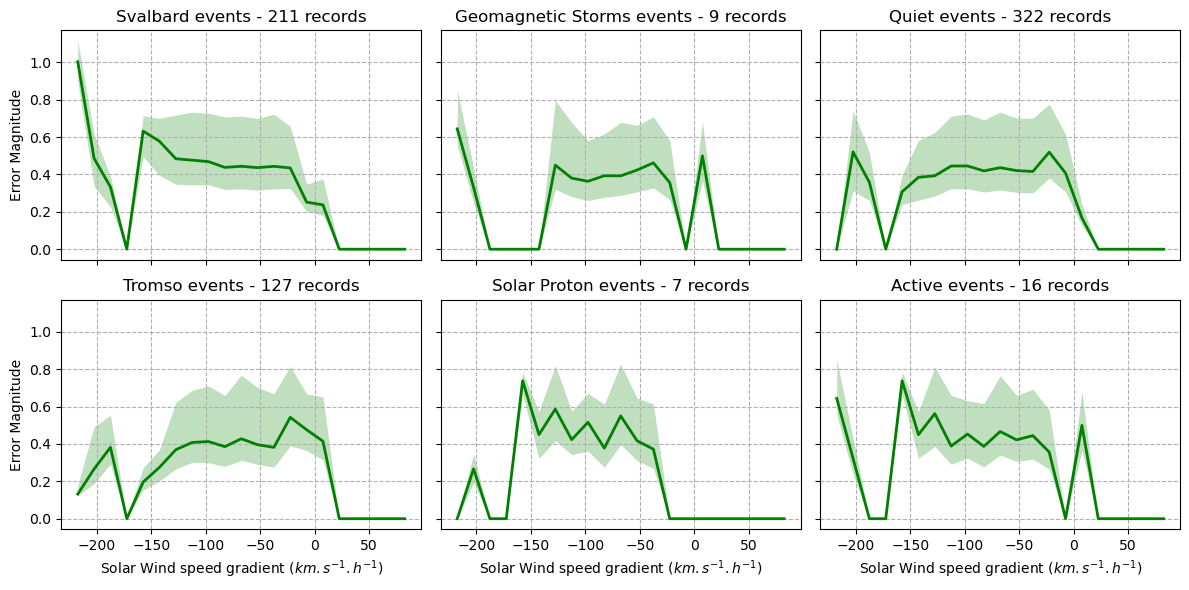

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

index_bins = np.linspace(-150,150,21)

for i in range(len(masks)):
    mask = masks[i]
    type = types[i]

    temp_Ne_EXP = Ne_EXP[mask]
    temp_Ne_WACCM = Ne_WACCM[mask]
    temp_dNe_EXP = dNe_EXP[mask]
    temp_index = dspeed_index[mask]

    temp_mag_EXP = mag_EXP[mask]
    temp_mag_WACCM = mag_WACCM[mask]

    temp_height = height[mask]

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    Ne_diff = np.abs(temp_Ne_EXP - temp_Ne_WACCM)
    error_mask = Ne_diff < temp_dNe_EXP

    temp_Ne_EXP[error_mask] = 1
    temp_dNe_EXP[error_mask] = 0

    dNe_fac = temp_dNe_EXP/temp_Ne_EXP
    factor_error_mask = dNe_fac > 2

    temp_Ne_EXP[factor_error_mask] = 1

    zero_mask = temp_Ne_EXP != 0
    temp_Ne_EXP[~zero_mask] = 1

    value_mask = temp_Ne_EXP != 1

    Ne_diff_flat = np.abs(temp_mag_EXP - temp_mag_WACCM)[value_mask]
    index_flat = temp_index[value_mask]

    mean_list = []
    less_sigma_list = []
    more_sigma_list = []


    for index_bin in index_bins:
        index_mask = np.abs(index_flat - index_bin) <= (index_bins[1] - index_bins[0])/2
        if len(Ne_diff_flat[index_mask]) == 0:
            mean_value = 0
            less_sigma_value = 0
            more_sigma_value = 0
        else:
            mean_value = np.mean(Ne_diff_flat[index_mask])
            less_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]<mean_value])
            more_sigma_value = np.std(Ne_diff_flat[index_mask][Ne_diff_flat[index_mask]>mean_value])
        mean_list.append(mean_value)
        less_sigma_list.append(less_sigma_value)
        more_sigma_list.append(more_sigma_value)

    mean = np.array(mean_list)
    less_sigma = np.array(less_sigma_list)
    more_sigma = np.array(more_sigma_list)
    
    x = np.array(index_bins)

    axs[i // 3][i % 3].fill_between(x + index_bins[1]/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
    axs[i // 3][i % 3].plot(x + index_bins[1]/2, mean, 'green', linewidth=2)
    axs[i // 3][i % 3].grid(linestyle='--')
    axs[i // 3][i % 3].set_title(f'{type} events - {sum(mask)} records')

axs[1][0].set_xlabel(r'Solar Wind speed gradient ($km.s^{-1}.h^{-1}$)')
axs[1][1].set_xlabel(r'Solar Wind speed gradient ($km.s^{-1}.h^{-1}$)')
axs[1][2].set_xlabel(r'Solar Wind speed gradient ($km.s^{-1}.h^{-1}$)')

axs[0][0].set_ylabel('Error Magnitude')
axs[1][0].set_ylabel('Error Magnitude')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/error-events/speed-gradient.png')
plt.show()